In [2]:
# Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

In [3]:
# Matplotlib and utils imports
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")
from utils import plot_stroke
import string
from sklearn.model_selection import KFold, train_test_split

In [4]:
strokes = np.load('../data/strokes-py3.npy', allow_pickle=True)
with open('../data/sentences.txt') as f:
    texts = f.readlines()
truncate = 100 
# texts is an array of strings
texts = texts[:truncate]
# strokes is a numpy array of float32 numpy arrays
strokes = strokes[:truncate]

In [5]:
def clean_sentence(sentence):
    # Remove newline character from a string
    return sentence.replace("\n", "")
data = [(clean_sentence(texts[i]), strokes[i]) for i in range(truncate)]
print(data[0][1].shape)
charset = {}
for sentence, _ in data :
    for char in sentence :
        if char not in charset :
            charset[char] = len(charset)
print(charset)

(739, 3)
{'i': 0, 'n': 1, ' ': 2, 't': 3, 'h': 4, 'e': 5, 'a': 6, 'b': 7, 'u': 8, 'd': 9, 'c': 10, 'o': 11, 'f': 12, 'p': 13, '"': 14, 'C': 15, 'g': 16, '-': 17, 'K': 18, 's': 19, 'l': 20, 'y': 21, '.': 22, 'I': 23, 'r': 24, ',': 25, 'v': 26, 'F': 27, 'm': 28, 'w': 29, 'A': 30, 'B': 31, 'R': 32, "'": 33, 'U': 34, 'N': 35, 'z': 36, 'G': 37, 'D': 38, 'M': 39, '!': 40, 'H': 41, ':': 42, 'x': 43, 'q': 44, 'P': 45, 'k': 46, 'O': 47, 'S': 48, ';': 49, 'Y': 50, 'T': 51, 'W': 52, '?': 53, 'L': 54, 'j': 55, '1': 56, '2': 57, '#': 58, 'V': 59, '6': 60, '9': 61, '0': 62}


In [6]:
def prepare_stroke(strokes):
    return torch.tensor(strokes)
 
def prepare_sentence(sentence : str):
    sentence_array = []
    for char in sentence :
        sentence_array.append(charset[char])
    return torch.tensor(sentence_array)
    

In [7]:
 class LSTM_scribe(nn.Module):
        def __init__(self, input_size, embedding_dim, charset_size, hidden_dim, n_gaussians):
            super(LSTM_scribe, self).__init__()
            self.hidden_dim = hidden_dim
            self.input_size = input_size
            self.char_embedding_dim = embedding_dim
            self.char_embedding = nn.Embedding(charset_size, embedding_dim)
            # specify batch_first=True because we feed data with shape (batch, seq_len, feature)
            self.hidden_1 = nn.LSTM(input_size, hidden_dim, batch_first=True)
            self.Wi_h1 = torch.ones(hidden_dim)
            self.old_window = torch.ones(hidden_dim)
            self.current_window = torch.ones(n_gaussians)
            # specify batch_first=True because we feed data with shape (batch, seq_len, feature)
            self.hidden_2 = nn.LSTM(input_size, hidden_dim, batch_first=True)
            self.K = n_gaussians
            self.alpha = [1]
            self.beta = [1]
            self.kappa = [1]
            self.linear = nn.Linear(hidden_dim, input_size)
            
            
        def forward(self, stroke, sentence):
            # is forward called at every "element" of a sequence, or once per sequence ???
            # on the answer to that will depend the writing of the forward function =>
            # the window layers is adapted to each "element" of a sequence...
            #print(f"input :{stroke.shape}")
            hidden_1_out, (hidden_1_h1, hidden_1_c1) = self.hidden_1(stroke)
            out = self.linear(hidden_1_out)
            return out
            print(f"From hidden_1 : {hidden_1_out.shape}, {hidden_1_h1.shape}, {hidden_1_c1.shape}")
            window_in = self.window_input(hidden_1_out, sentence)
            window_out = self.window_function(window_in)
            hidden_2_in = self.hidden_2_input(stroke)
            hidden_2_out, _ = self.hidden_2(hidden_2_in)
            out = self.output_function(hidden_2_out)
            return out
        
        
        def window_input(self, hidden_1_out, sentence):
            # embed the characters and combine it with the weights from first layer
            sentence_vector = prepare_sentence(sentence)
            embeds = self.char_embedding(sentence_vector)
            print(f"input to window : {hidden_1_out.shape}, {embeds.shape}")
            return hidden_1_out, embeds
        
        def phi(self, u):
            # Add grad operations to differentiate on the whole thing
            result = 0
            for k in range(self.K):
                alpha = self.alpha[k]
                beta = self.beta[k]
                kappa = self.kappa[k]
                result += self.alpha[k] * np.exp(-beta*(kappa - u)**2)
            return result
        
        def w(self, sentence_embedded):
            # Add grad operations to differentiate on the whole thing
            w = 0
            l = len(sentence_embedded)
            for u in range(l):
                w += self.phi(u) * sentence_embedded[u]
            return w 
        
        def window_function(self, window_in):
            hidden1_out, embeds = window_in
            w_t = self.w(embeds)
            print(f"w_t: {w_t.shape} \n {w_t}")
            
        
        def hidden_2_input(self, stroke):
            # Recombine output from window, input sequence and previous hidden state and
            # first hidden layer
            print(f"h2i : {stroke.shape}")
            return stroke
        
        def output_function(self, hidden_2_out):
            # Go from 20 dimensions to 3 dimensions
            print(f"of : {hidden_2_out.shape}")
            return hidden_2_out
        


In [8]:
parameters = {
    "input_size" : 3,
    "embedding_dim": 15,
    "charset_size": 16,
    "hidden_dim": 17,
    "n_gaussians": 1,
}
print(f"Data with {len(data)} samples ")
model = LSTM_scribe(**parameters)
loss_function = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters())

for epoch in range(1):
    for k, (sentence, strokes) in enumerate(data) :
        model.zero_grad()
        strokes_in = prepare_stroke(strokes)
        # resize to fit the (batch, )
        strokes_in = strokes_in.reshape(1, strokes_in.shape[0], -1)
        out = model(strokes_in, sentence)
        # dimension problem in the loss, comparing the hidden-state output with the 3 dimension stroke
        
        if k % 5 == 0 :
            print(k , out.shape, strokes_in.shape)
        loss = loss_function(out, strokes_in)
        loss.backward()
        optimizer.step
 

Data with 100 samples 
0 torch.Size([1, 739, 3]) torch.Size([1, 739, 3])
5 torch.Size([1, 377, 3]) torch.Size([1, 377, 3])
10 torch.Size([1, 674, 3]) torch.Size([1, 674, 3])
15 torch.Size([1, 629, 3]) torch.Size([1, 629, 3])
20 torch.Size([1, 494, 3]) torch.Size([1, 494, 3])
25 torch.Size([1, 852, 3]) torch.Size([1, 852, 3])
30 torch.Size([1, 458, 3]) torch.Size([1, 458, 3])
35 torch.Size([1, 769, 3]) torch.Size([1, 769, 3])
40 torch.Size([1, 1144, 3]) torch.Size([1, 1144, 3])
45 torch.Size([1, 739, 3]) torch.Size([1, 739, 3])
50 torch.Size([1, 434, 3]) torch.Size([1, 434, 3])
55 torch.Size([1, 724, 3]) torch.Size([1, 724, 3])
60 torch.Size([1, 461, 3]) torch.Size([1, 461, 3])
65 torch.Size([1, 721, 3]) torch.Size([1, 721, 3])
70 torch.Size([1, 661, 3]) torch.Size([1, 661, 3])
75 torch.Size([1, 477, 3]) torch.Size([1, 477, 3])
80 torch.Size([1, 423, 3]) torch.Size([1, 423, 3])
85 torch.Size([1, 786, 3]) torch.Size([1, 786, 3])
90 torch.Size([1, 797, 3]) torch.Size([1, 797, 3])
95 torch

tensor([[ 1.0000,  0.0784,  0.1578],
        [-0.0467,  0.0897,  0.1504],
        [-0.0504,  0.0983,  0.1430],
        ...,
        [-0.0342,  0.0522,  0.2580],
        [-0.0382,  0.0528,  0.2596],
        [ 1.0000,  0.0238,  0.2575]])


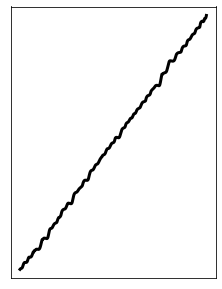

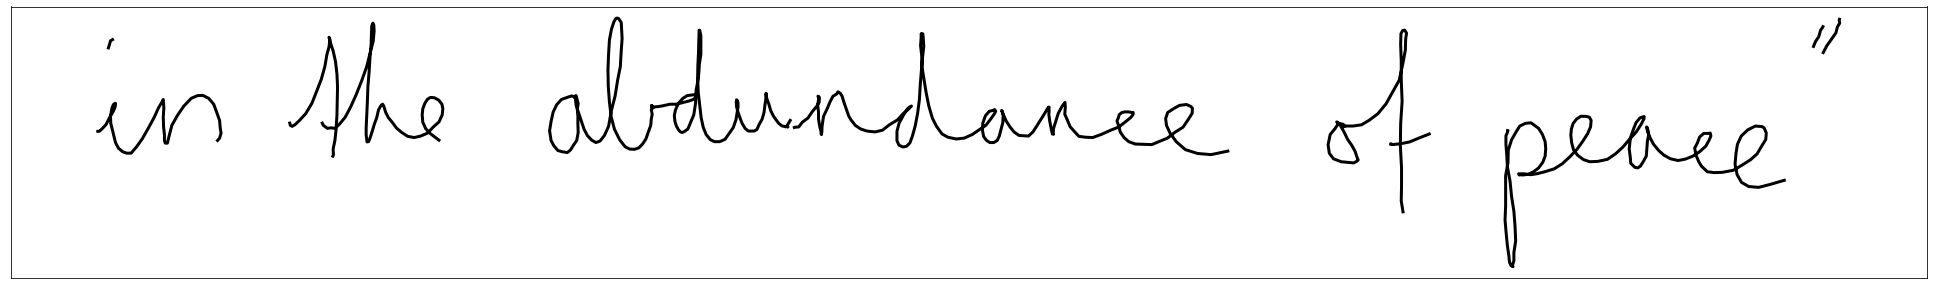

In [13]:
   
with torch.no_grad():
    strokes_in = prepare_stroke(data[0][1])
    strokes = strokes_in.clone().detach()
    strokes_in = strokes_in.reshape(1, strokes_in.shape[0], -1)
    sentence_in = data[0][0]
    example =  model(strokes_in, sentence)
    example = example.reshape(example.shape[1], example.shape[2])
    o = example.clone().detach()
    o[0][0] = 1
    o[-1][0] = 1
    print(o)
    plot_stroke(o)
    #plot_stroke(strokes[0])
    plot_stroke(strokes)